# Kaggle cats-or-dogs binary classification

* Building a convolutional neural network for binary classification of images.
* 3,000 JPG pictures of cats and dogs from the ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) available on Kaggle.
* Transfer learning from a pretrained Inception V3 model
* Data augmentation and dropout for avoiding overffiting
* History of training/validation accuracy and loss.

Retrain an existing Inception V3 that is already trained with much more data set

Optimizer: RMSprop with learning rate = 0.001

Loss function: binary cross-entropy

## Download the cat and dog images

In [2]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O ~/Downloads/cats_and_dogs_filtered.zip

--2020-05-21 17:32:27--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.4.48
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.4.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/Users/johanzhuohan/Downloads/cats_and_dogs_filtered.zip’

/Users/johanzhuohan 100%[===================>]  65.43M  23.3MB/s    in 2.8s    

2020-05-21 17:32:30 (23.3 MB/s) - ‘/Users/johanzhuohan/Downloads/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [3]:
import os
import zipfile

local_zip = '/Users/johanzhuohan/Downloads/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/Users/johanzhuohan/Downloads')
zip_ref.close()

In [4]:
base_dir = '/Users/johanzhuohan/Downloads/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_cats_names = os.listdir(train_cats_dir)
train_dogs_dir = os.path.join(train_dir, 'dogs')
train_dogs_names = os.listdir(train_dogs_dir)

# Directory with our validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [5]:
print('total training cat images :', len(os.listdir(      train_cats_dir ) ))
print('total training dog images :', len(os.listdir(      train_dogs_dir ) ))

print('total validation cat images :', len(os.listdir( validation_cats_dir ) ))
print('total validation dog images :', len(os.listdir( validation_dogs_dir ) ))

total training cat images : 1000
total training dog images : 1000
total validation cat images : 500
total validation dog images : 500


## Downloading trained inception neural network: transfer learning

In [6]:
from tensorflow.keras import layers
from tensorflow.keras import Model

# Download the existing model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

--2020-05-21 17:32:42--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.4.48
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.4.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  22.7MB/s    in 4.0s    

2020-05-21 17:32:47 (20.9 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



## Training a Convolutional neural network without dropout

Here we will train a model with augmented data set, but without dropout.

In [115]:
# import the model skeleton
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Fill in the existing model to the skeleton
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, # ignore the first default dence layer
                                weights = None)
pre_trained_model.load_weights(local_weights_file)

# Lock the convolution layers
for layer in pre_trained_model.layers:
    layer.trainable = False

# pre_trained_model.summary()

# Get the output from the last convolution layer
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [116]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with ReLU activation
x = layers.Dense(1024, activation='relu')(x)                 
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model1 = Model( pre_trained_model.input, x) 

In [117]:
model1.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_190 (BatchN (None, 74, 74, 32)   96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 74, 74, 32)   0           batch_normalization_190[0][0]    
___________________________________________________________________________________________

* Set the optimizer and the loss function

In [118]:
from tensorflow.keras.optimizers import RMSprop

model1.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.0002),
              metrics=['acc'])

* Data processing with data augmentation for train set

In [119]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentation for train data set
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     

validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


* Training without dropout

In [120]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [122]:
history1 = model1.fit_generator(train_generator,
                                validation_data=validation_generator,
                                steps_per_epoch=100,
                                epochs=40,
                                validation_steps=50,
                                callbacks=[es, mc],
                                verbose=1)

Epoch 1/40
 99/100 [============================>.] - ETA: 1s - loss: 0.5428 - acc: 0.7525  

## Accuracy and Loss history without dropout

* Accuracy > ~ 85 % can be got without dropout.
* This accuracy is higher than training the model from scrach (only < 80% accuracy in Kaggle_cats_or_dogs_CNN2.ipynb).
* The validation loss fluctuates a lot, and is increasing overall, which means the confidence on the prediction is getting lower.

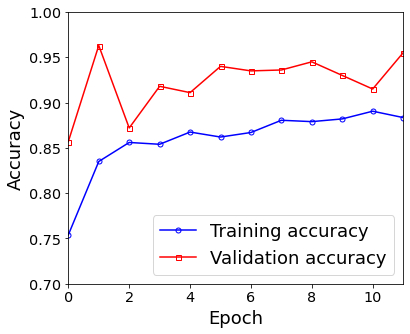

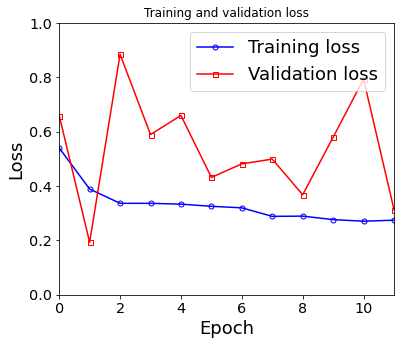

In [132]:
import matplotlib.pyplot as plt

acc = history1.history[ 'acc' ]
val_acc = history1.history[ 'val_acc' ]
loss = history1.history[ 'loss' ]
val_loss = history1.history['val_loss' ]

epochs = range(len(acc)) # Get number of epochs

markers = 5
font = 18
# Accuracy
fig, ax = plt.subplots(figsize = (6,5))
ax.plot  ( epochs, acc, 'bo-', label='Training accuracy', markerfacecolor="None",markersize=markers )
ax.plot  ( epochs, val_acc, 'rs-', label='Validation accuracy', markerfacecolor="None",markersize=markers )
#ax.set_title ('Training and validation accuracy', fontsize=font)
ax.set_xlabel('Epoch', fontsize=font)
ax.set_ylabel('Accuracy', fontsize=font)
ax.set(xlim=[0,epochs[-1]], ylim=[0.7,1.0])
ax.tick_params(axis='both', which='major',labelsize = font*0.8)
ax.legend(loc='lower right',frameon=True,fontsize=font)

# Loss
fig, ax = plt.subplots(figsize = (6,5))
plt.plot  ( epochs, loss, 'bo-', label='Training loss', markerfacecolor="None",markersize=markers )
plt.plot  ( epochs, val_loss, 'rs-', label='Validation loss', markerfacecolor="None",markersize=markers )
#ax.set_title ('Training and validation loss', fontsize=font)
ax.set_xlabel('Epoch', fontsize=font)
ax.set_ylabel('Loss', fontsize=font)
ax.set(xlim=[0,epochs[-1]],ylim=[0,1.0])
ax.tick_params(axis='both', which='major',labelsize = font*0.8)
ax.legend(loc='upper right',frameon=True,fontsize=font)
plt.show()

## Training a Convolutional neural network with dropout

Here we will train a model with augmented data set and with dropout. It will be clear, dropout can help train the model better. This is because in NN, neighbor neurons somtimes learn similar features, and it skews the model to some specific features, resulting in overfitting. By randomly dropping out some of the neurons, overfitting can be possiblly avoided.

In [125]:
# import the model skeleton
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Fill in the existing model to the skeleton
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, # ignore the first default dence layer
                                weights = None)
pre_trained_model.load_weights(local_weights_file)

# Lock the convolution layers
for layer in pre_trained_model.layers:
    layer.trainable = False

# pre_trained_model.summary()

# Get the output from the last convolution layer
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [126]:
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)                 
# Dropout 20%
x = layers.Dropout(0.2)(x)
x = layers.Dense  (1, activation='sigmoid')(x)           

model2 = Model( pre_trained_model.input, x) 

In [127]:
model2.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_376 (Conv2D)             (None, 74, 74, 32)   864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_378 (BatchN (None, 74, 74, 32)   96          conv2d_376[0][0]                 
__________________________________________________________________________________________________
activation_376 (Activation)     (None, 74, 74, 32)   0           batch_normalization_378[0][0]    
___________________________________________________________________________________________

In [128]:
from tensorflow.keras.optimizers import RMSprop

model2.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.0002),
              metrics=['acc'])

* Data augmentation

In [129]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for the training data set
train_datagen = ImageDataGenerator( 
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest' )
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))   

# Validation data set
validation_datagen  = ImageDataGenerator( rescale = 1.0/255. )

validation_generator =  validation_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


* Training with dropout

In [130]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [131]:
history2 = model2.fit_generator(train_generator,
                                validation_data=validation_generator,
                                steps_per_epoch=100,
                                epochs=40,
                                validation_steps=50,
                                callbacks=[es, mc],
                                verbose=1)

Epoch 1/40
 99/100 [============================>.] - ETA: 1s - loss: 0.5572 - acc: 0.7616  

## Accuracy and Loss history with dropout

* As it can be seen, training the CNN model with dropout makes the fluctuations in both validation accuracy and validation loss smaller.
* The validation accuracy stays above ~90% for the first 20 epochs, but the accuracy and loss starts to fluctuates in a large range for further training. In other words, overfitting can still happen for too long training for a small data set, even if with dropout and data augmentation.
* Early stopping is still needed for obtaining the best model during the training.

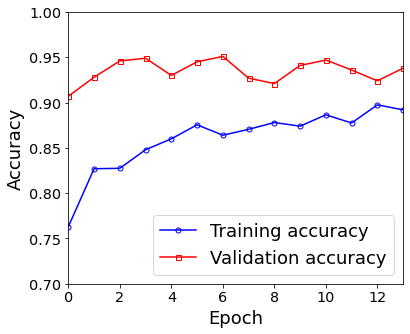

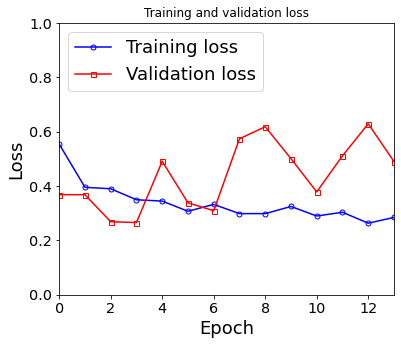

In [133]:
import matplotlib.pyplot as plt

acc = history2.history[ 'acc' ]
val_acc = history2.history[ 'val_acc' ]
loss = history2.history[ 'loss' ]
val_loss = history2.history['val_loss' ]

epochs = range(len(acc)) # Get number of epochs

markers = 5
font = 18
# Accuracy
fig, ax = plt.subplots(figsize = (6,5))
ax.plot  ( epochs, acc, 'bo-', label='Training accuracy', markerfacecolor="None",markersize=markers )
ax.plot  ( epochs, val_acc, 'rs-', label='Validation accuracy', markerfacecolor="None",markersize=markers )
#ax.set_title ('Training and validation accuracy', fontsize=font)
ax.set_xlabel('Epoch', fontsize=font)
ax.set_ylabel('Accuracy', fontsize=font)
ax.set(xlim=[0,epochs[-1]], ylim=[0.7,1.0])
ax.tick_params(axis='both', which='major',labelsize = font*0.8)
ax.legend(loc='lower right',frameon=True,fontsize=font)

# Loss
fig, ax = plt.subplots(figsize = (6,5))
plt.plot  ( epochs, loss, 'bo-', label='Training loss', markerfacecolor="None",markersize=markers )
plt.plot  ( epochs, val_loss, 'rs-', label='Validation loss', markerfacecolor="None",markersize=markers )
#ax.set_title ('Training and validation loss', fontsize=font)
ax.set_xlabel('Epoch', fontsize=font)
ax.set_ylabel('Loss', fontsize=font)
ax.set(xlim=[0,epochs[-1]],ylim=[0,1.0])
ax.tick_params(axis='both', which='major',labelsize = font*0.8)
ax.legend(loc='upper left',frameon=True,fontsize=font)
plt.show()

# Retraining a  transfered layers, and with global average pooling

In [7]:
# import the model skeleton
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Fill in the existing model to the skeleton
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, # ignore the first default dence layer
                                weights = None)
pre_trained_model.load_weights(local_weights_file)

In [8]:
# Unlock the convolution layers
unlock = 100
count = 0
train = True
for layer in reversed(pre_trained_model.layers):
    count += 1
    layer.trainable = train
    if count >= unlock:
        train = False

In [9]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [10]:
# Get the output from the last convolution layer
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [11]:
# global average pooling instead of flattening
x = layers.GlobalAveragePooling2D()(last_output)
x = layers.Dense(1024, activation='relu')(x)                 
x = layers.Dense  (1, activation='sigmoid')(x)           

model3 = Model( pre_trained_model.input, x) 

In [12]:
from tensorflow.keras.optimizers import RMSprop

model3.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.0001), # lowering learning rate when fine-tuning
              metrics=['acc'])

In [13]:
model3.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for the training data set
train_datagen = ImageDataGenerator( 
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest' )
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))   

# Validation data set
validation_datagen  = ImageDataGenerator( rescale = 1.0/255. )

validation_generator =  validation_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [15]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [16]:
history3 = model3.fit_generator(train_generator,
                                validation_data=validation_generator,
                                steps_per_epoch=100,
                                epochs=40,
                                validation_steps=50,
                                callbacks=[es, mc],
                                verbose=1)

Epoch 1/40


W0521 17:33:10.347406 140734879802816 deprecation.py:323] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


 99/100 [============================>.] - ETA: 0s - loss: 0.5540 - acc: 0.7808   

In [17]:
# import matplotlib.pyplot as plt

acc = history3.history[ 'acc' ]
val_acc = history3.history[ 'val_acc' ]
loss = history3.history[ 'loss' ]
val_loss = history3.history['val_loss' ]

epochs = range(len(acc)) # Get number of epochs

markers = 5
font = 18
# Accuracy
fig, ax = plt.subplots(figsize = (6,5))
ax.plot  ( epochs, acc, 'bo-', label='Training accuracy', markerfacecolor="None",markersize=markers )
ax.plot  ( epochs, val_acc, 'rs-', label='Validation accuracy', markerfacecolor="None",markersize=markers )
#ax.set_title ('Training and validation accuracy', fontsize=font)
ax.set_xlabel('Epoch', fontsize=font)
ax.set_ylabel('Accuracy', fontsize=font)
ax.set(xlim=[0,epochs[-1]], ylim=[0.7,1.0])
ax.tick_params(axis='both', which='major',labelsize = font*0.8)
ax.legend(loc='lower right',frameon=True,fontsize=font)

# Loss
fig, ax = plt.subplots(figsize = (6,5))
plt.plot  ( epochs, loss, 'bo-', label='Training loss', markerfacecolor="None",markersize=markers )
plt.plot  ( epochs, val_loss, 'rs-', label='Validation loss', markerfacecolor="None",markersize=markers )
#ax.set_title ('Training and validation loss', fontsize=font)
ax.set_xlabel('Epoch', fontsize=font)
ax.set_ylabel('Loss', fontsize=font)
ax.set(xlim=[0,epochs[-1]],ylim=[0,1.0])
ax.tick_params(axis='both', which='major',labelsize = font*0.8)
ax.legend(loc='upper left',frameon=True,fontsize=font)
plt.show()

NameError: name 'plt' is not defined